#Checkpoint 3: Ensambles



Enunciado:

* Construir un clasificador KNN optimizar sus hiperparámetros mediante k-fold
Cross Validation
* Construir un clasificador SVM variando el kernel y los parámetros.
* Construir un clasificador RF y optimizar sus hiperparámetros mediante k-fold
Cross Validation
* Construir un clasificador XGBoost y optimizar sus hiperparámetros.
* Construir un ensamble híbrido tipo Voting y otro tipo Stacking.
* Evaluar la performance de todos los modelos en entrenamiento y validación,
explicar todas las métricas y mostrar la matriz de confusión.
* Generar predicciones con el set de test y realizar los submits correspondientes en
la competencia de Kaggle.

## Importamos librerías y datasets

Importamos librerías:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip install 'dtreeviz'
import pandas as pd
import numpy as np
#librerias para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz
#modelos
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score,accuracy_score,f1_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

import time
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.5 MB/s eta 0:00:00


Montamos Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos datasets:

In [ ]:
ds_hoteles_train = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/hoteles_train_exportado.csv')
ds_hoteles_test = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/hotels_test.csv')
ds_paises_continentes = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/tabla_pais_continente.csv')

### Hacemos la copia de los datasets

In [ ]:
ds_hoteles_train_copy = ds_hoteles_train.copy()
ds_hoteles_test_copy = ds_hoteles_test.copy()
ds_paises_continentes_copy = ds_paises_continentes.copy()

## Realizamos transformaciones

Realizamos las mismas transformaciones que en el checkpoint anterior:

### En train

In [ ]:
#country / nombre_continente
moda_country = ds_hoteles_train_copy['country'].mode().iloc[0]
ds_hoteles_train_copy['country'].fillna(moda_country, inplace=True)
ds_hoteles_train_copy['country'].unique()

ds_paises_continentes_copy.rename(columns={'alpha-3': 'country', 'region': 'nombre_continente'}, inplace=True)
ds_hoteles_train_copy = pd.merge(ds_hoteles_train_copy, ds_paises_continentes_copy[['country','nombre_continente']],on='country', how='left')

ds_hoteles_train_copy.loc[ds_hoteles_train_copy['country'] == 'CN', 'nombre_continente'] = "Asia"
ds_hoteles_train_copy.loc[ds_hoteles_train_copy['country'] == 'ATA', 'nombre_continente'] = "Antartica"

ds_hoteles_train_copy.drop(['country'], axis=1, inplace=True)

#arrival_time
ds_hoteles_train_copy['arrival_date'] = pd.to_datetime(ds_hoteles_train_copy['arrival_date'])
ds_hoteles_train_copy['arrival_date'] = ds_hoteles_train_copy['arrival_date'].astype(int)

#One-hot encoding
vars_a_onehot = ['hotel','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type','meal','nombre_continente']

#Les aplicamos One Hot Encoding
ds_hoteles_train_copy = pd.get_dummies(ds_hoteles_train_copy, columns=vars_a_onehot, drop_first=True)

### En test

In [ ]:
#Obtengo la moda
moda_country = ds_hoteles_test_copy['country'].mode().iloc[0]

#Reemplazar los NaN por la moda de 'country'
ds_hoteles_test_copy['country'].fillna(moda_country, inplace=True)

#Obtenemos un nuevo dataframe, donde unimos las columnas de hoteles_test_copy y df_Tabla_Pais_Continente_copy
ds_hoteles_test_copy = pd.merge(ds_hoteles_test_copy,ds_paises_continentes_copy[['country','nombre_continente']],on='country', how='left')

#Reemplazamos los valores de continente donde eran NaN (o NULL)
ds_hoteles_test_copy.loc[ds_hoteles_test_copy['country'] == 'CN', 'nombre_continente'] = "Asia"
ds_hoteles_test_copy.loc[ds_hoteles_test_copy['country'] == 'ATA', 'nombre_continente'] = "Antartica"

#Eliminamos la variable country
ds_hoteles_test_copy.drop(['country'], axis=1, inplace=True)

In [ ]:
#Me guardo la columna id antes de borrarla
ds_hoteles_test_id = ds_hoteles_test_copy['id']

In [ ]:
#Eliminamos la columna 'company' e 'id'
ds_hoteles_test_copy.drop(["company", "id"], axis=1, inplace=True)

#Obtenemos la moda de children y agent
moda_children = pd.Series(ds_hoteles_test_copy['children'].values.flatten()).mode()[0]
moda_agent = pd.Series(ds_hoteles_test_copy['agent'].values.flatten()).mode()[0]

#Reemplazamos los NaN de ambas columnas por la moda
ds_hoteles_test_copy["children"] = ds_hoteles_test_copy["children"].fillna(moda_children)
ds_hoteles_test_copy["agent"] = ds_hoteles_test_copy["agent"].fillna(moda_agent)

#Reemplazamos 'Undefined' por 'SC' en la columna meal
ds_hoteles_test_copy['meal'].replace('Undefined', 'SC', inplace = True)

#Además vamos a eliminar la columna de reservation_status_date:
ds_hoteles_test_copy.drop(["reservation_status_date"], axis=1,inplace=True)

# Crear una nueva columna 'arrival_date' combinando las variables con el número de semana
ds_hoteles_test_copy['arrival_date'] = pd.to_datetime(ds_hoteles_test_copy['arrival_date_year'].astype(str) + '-' + ds_hoteles_test_copy['arrival_date_month'] + '-' + ds_hoteles_test['arrival_date_day_of_month'].astype(str), format='%Y-%B-%d')
ds_hoteles_test_copy['arrival_date'] = ds_hoteles_test_copy['arrival_date'].astype(int)

#Borramos las columnas arrival_date_year; arrival_date_month; arrival_date_day_of_month
ds_hoteles_test_copy.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], axis=1,inplace=True)



In [ ]:
#Les aplicamos One Hot Encoding a las misma variables que en train
ds_hoteles_test_copy = pd.get_dummies(ds_hoteles_test_copy, columns=vars_a_onehot, drop_first=True)

#Creamos la variable 'assigned_room_type_L' en el dataset de test y la llenamos de ceros
ds_hoteles_test_copy['assigned_room_type_L'] = 0

Ordenamos las columnas de ambos datasets alfabeticamente:

In [ ]:
ds_hoteles_train_copy = ds_hoteles_train_copy.reindex(sorted(ds_hoteles_train_copy.columns), axis=1)
ds_hoteles_test_copy = ds_hoteles_test_copy.reindex(sorted(ds_hoteles_test_copy.columns), axis=1)

Comprobamos que la limpieza esté correcta:

In [ ]:
ds_hoteles_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61909 entries, 0 to 61908
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           61909 non-null  object 
 1   lead_time                       61909 non-null  int64  
 2   arrival_date_week_number        61909 non-null  int64  
 3   stays_in_weekend_nights         61909 non-null  int64  
 4   stays_in_week_nights            61909 non-null  int64  
 5   adults                          61909 non-null  int64  
 6   children                        61909 non-null  float64
 7   babies                          61909 non-null  int64  
 8   meal                            61909 non-null  object 
 9   country                         61688 non-null  object 
 10  market_segment                  61909 non-null  object 
 11  distribution_channel            61909 non-null  object 
 12  is_repeated_guest               

In [ ]:
ds_hoteles_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

## Realizamos una division de train para pruebas

### Aplicamos el train_test_split

In [ ]:
ds_hoteles_train_x = ds_hoteles_train_copy.drop('is_canceled', axis = 1)
ds_hoteles_train_y = ds_hoteles_train_copy['is_canceled']

ds_test_x = ds_hoteles_test_copy

x_train, x_test, y_train, y_test = train_test_split(ds_hoteles_train_x,
                                                    ds_hoteles_train_y,
                                                    test_size=0.30,
                                                    random_state = 99,
                                                    stratify= ds_hoteles_train['is_canceled'].values)

Como resultado, x_train contendrá el 70% de los datos originales en ds_hoteles_train_x

In [ ]:
are_equal_size = len(ds_hoteles_train_x) == len(x_train)
are_equal_size
print(len(ds_hoteles_train_x))
print(len(x_train))

61909
43336


## Construimos un clasificador KNN y optimizamos sus hiperparámetros mediante k-fold Cross Validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Construimos un modelo con parámetros por defecto

Creamos el modelo y observamos los parámetros por defecto:

In [ ]:
KNN_Classifier = KNeighborsClassifier()
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Entrenamos el modelo con nuestra división del dataset:

In [ ]:
KNN_Classifier.fit(x_train, y_train)
y_pred = KNN_Classifier.predict(x_test)

#### Evaluamos sus métricas

Observamos sus metricas:

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56      9292
           1       0.55      0.54      0.55      9281

    accuracy                           0.55     18573
   macro avg       0.55      0.55      0.55     18573
weighted avg       0.55      0.55      0.55     18573



Obtenemos un 0.55 en f1-score que es bastante menor en comparación con los modelos de árboles donde obtuvimos entre 0.79-0.83.

#### Matriz de confusión

Imprimimos su matriz de confusión:

Text(50.722222222222214, 0.5, 'Valores reales')

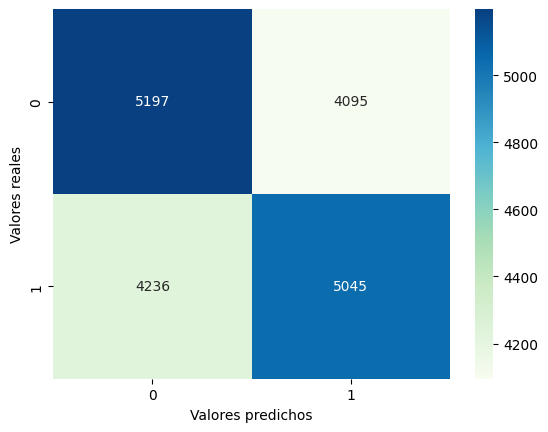

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### Optimizamos hiperparámetros

Probamos variaciones de cantidad de vecinos:

In [ ]:
len(x_test)/1000

18.573

In [ ]:
# Variamos la cantidad de vecinos (K)

reducir_pasos = 1000

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, int(len(x_test)/reducir_pasos)) # vecinos desde 1 hasta cantidad total de puntos en test

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, (y_test == y_pred).sum()))
    n = n + reducir_pasos

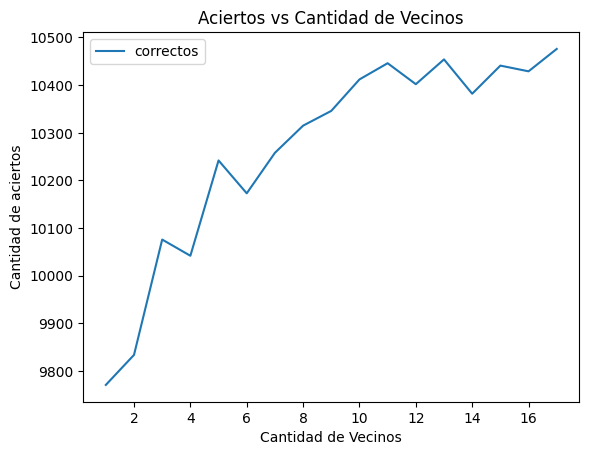

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos',
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [ ]:
#Otra forma de hacer lo mismo pero mas espaciado
max_cantidad_vecinos = 200
cantidad_pasos = 10

n = 1
while n < max_cantidad_vecinos:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(x_train, y_train)
  y_pred = knn.predict(x_test)
  metrics.append((n, (y_test == y_pred).sum()))
  n = n + int(max_cantidad_vecinos / cantidad_pasos)

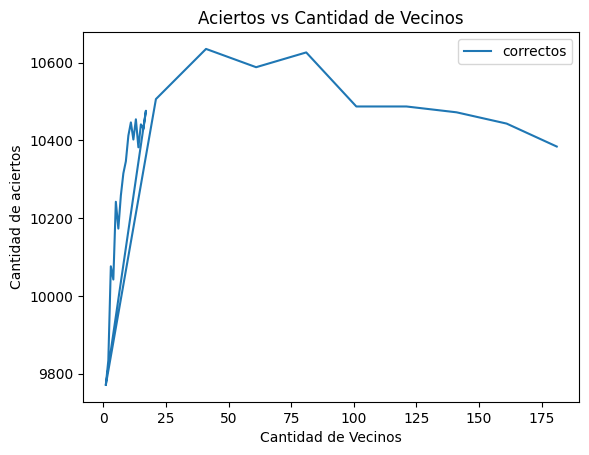

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos',
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [ ]:
max(metrics)

(181, 10384)

In [ ]:
metrics.sort(reverse=True)
metrics

[(181, 10384),
 (161, 10443),
 (141, 10472),
 (121, 10487),
 (101, 10487),
 (81, 10626),
 (61, 10588),
 (41, 10635),
 (21, 10506),
 (17, 10476),
 (16, 10429),
 (15, 10441),
 (14, 10382),
 (13, 10454),
 (12, 10402),
 (11, 10446),
 (10, 10412),
 (9, 10346),
 (8, 10315),
 (7, 10258),
 (6, 10173),
 (5, 10242),
 (4, 10042),
 (3, 10076),
 (2, 9834),
 (1, 9771),
 (1, 9771)]

Podemos observar que 181 vecinos nos dio la mayor cantidad de aciertos

Con Random Search CV buscamos los otros mejores parámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

iteraciones = 50
folds = 20
#Grilla de Parámetros
params_grid={ 'n_neighbors': range(1,200),
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search
rand = RandomizedSearchCV(knn, params_grid, cv=folds, scoring='f1', n_iter=iteraciones, random_state=5)

#rand.fit(x_train, y_train)
rand.fit(ds_hoteles_train_x, ds_hoteles_train_y)

RandomizedSearchCV(cv=20, estimator=KNeighborsClassifier(), n_iter=50,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(1, 200),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, scoring='f1')

In [ ]:
#Mejores hiperparametros del arbol
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'brute'}
0.7417862384408203


In [ ]:
rand.cv_results_['mean_test_score']

array([0.55967005, 0.7408259 , 0.57757695, 0.56096391, 0.57166352,
       0.56339612, 0.72456959, 0.56108656, 0.5884317 , 0.72674172,
       0.57858683, 0.57423514, 0.74178624, 0.72994177, 0.7311243 ,
       0.56808969, 0.73960425, 0.63228344, 0.73096993, 0.56852075,
       0.60586804, 0.72726859, 0.58449023, 0.70183216, 0.73086469,
       0.58016812, 0.73353136, 0.72670172, 0.57361571, 0.72448722,
       0.73447611, 0.72443726, 0.57499168, 0.73362393, 0.68607602,
       0.56609487, 0.56712271, 0.58485296, 0.36631978, 0.73085825,
       0.72448651, 0.57287757, 0.73448626, 0.73190127, 0.57249283,
       0.73493896, 0.58493721, 0.55881521, 0.61134895, 0.56182172])

In [ ]:
#f-score = 0.71
#knn_mejores_hiperparametros = {'weights': 'distance', 'n_neighbors': 101, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
#f-score = 0.73
#knn_mejores_hiperparametros = {'weights': 'distance', 'n_neighbors': 4, 'metric': 'chebyshev', 'algorithm': 'brute'}
#f-score = 0.74
knn_mejores_hiperparametros = {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'brute'}

In [ ]:
mejor_knn = rand.best_estimator_
mejor_knn.fit(x_train, y_train)
y_pred = mejor_knn.predict(x_test)

Realizamos cross-validation:

In [ ]:
from sklearn.model_selection import cross_val_score
mejor_knn = KNeighborsClassifier(**knn_mejores_hiperparametros)
scores = cross_val_score(mejor_knn, ds_hoteles_train_x, ds_hoteles_train_y, cv=10, scoring='f1')
scores

array([0.74783167, 0.74926829, 0.75823293, 0.75649968, 0.75616438,
       0.74838918, 0.75630789, 0.75282349, 0.74943639, 0.76078935])

Imprimimos su matriz de confusión:

Text(50.722222222222214, 0.5, 'Valores reales')

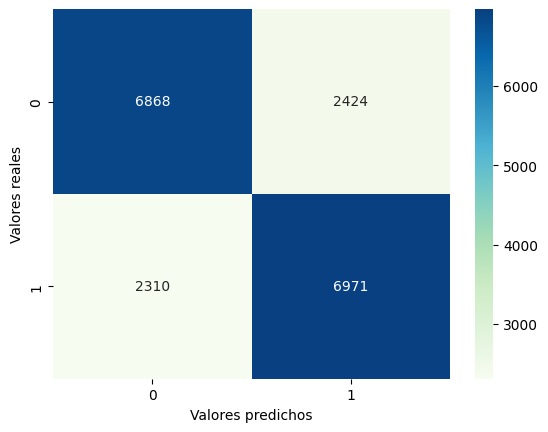

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      9292
           1       0.74      0.75      0.75      9281

    accuracy                           0.75     18573
   macro avg       0.75      0.75      0.75     18573
weighted avg       0.75      0.75      0.75     18573



### Generamos predicciones con el set de test

Entrenamos el modelo con el 100% de train:

In [ ]:
mejor_knn = KNeighborsClassifier(**knn_mejores_hiperparametros)
mejor_knn.fit(ds_hoteles_train_x, ds_hoteles_train_y)
y_pred_mejor_knn = mejor_knn.predict(ds_test_x)

In [ ]:
df_submission = pd.DataFrame({'id': ds_hoteles_test_id,'is_canceled': y_pred_mejor_knn})
df_submission.info()
df_submission.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/submission_kaggle_knn_mejor_v2.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 621.9+ KB


## Construimos un clasificador SVM variando el kernel y los parámetros.

### Creamos un modelo con parámetros por defecto



In [ ]:
#Construyo un modelo SVM
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.51      0.52      0.51      9225
           1       0.52      0.52      0.52      9348

    accuracy                           0.52     18573
   macro avg       0.52      0.52      0.52     18573
weighted avg       0.52      0.52      0.52     18573



Normalizamos los datos: (Tanto con min/max scaler como con standard scaler)

In [ ]:
#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_test_minmax  = min_max_scaler.transform(x_test)

ds_train_minmax = min_max_scaler.fit_transform(ds_hoteles_train_x)
ds_test_minmax = min_max_scaler.fit_transform(ds_hoteles_test_copy)

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

ds_train_norm = min_max_scaler.fit_transform(ds_hoteles_train_x)
ds_test_norm = min_max_scaler.fit_transform(ds_hoteles_test_copy)

Probamos crear el modelo con los datos normalizados (standard scaler)

In [ ]:
#Construyo un modelo SVM
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
print(classification_report(y_pred_norm,y_test))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     10230
           1       0.76      0.84      0.80      8343

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573



Imprimimos su matriz de confusión:

Text(50.722222222222214, 0.5, 'Valores reales')

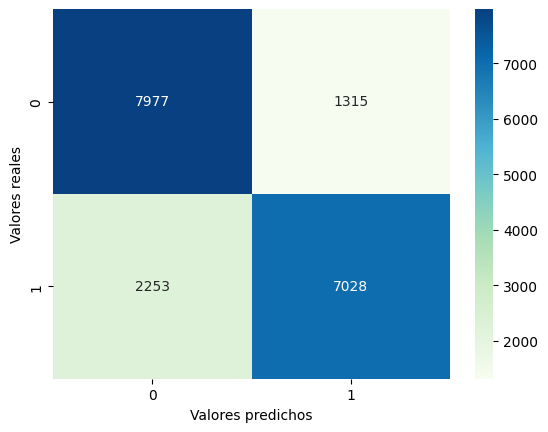

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_norm)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

Probamos crear el modelo con los datos normalizados (min/max scaler)

In [ ]:
#Construyo un modelo SVM
svm_minmax= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_minmax.fit(x_train_minmax, y_train)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(x_test_minmax)
print(classification_report(y_pred_minmax, y_test))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79     10414
           1       0.72      0.82      0.77      8159

    accuracy                           0.78     18573
   macro avg       0.78      0.79      0.78     18573
weighted avg       0.79      0.78      0.78     18573



Imprimimos su matriz de confusión:

Text(50.722222222222214, 0.5, 'Valores reales')

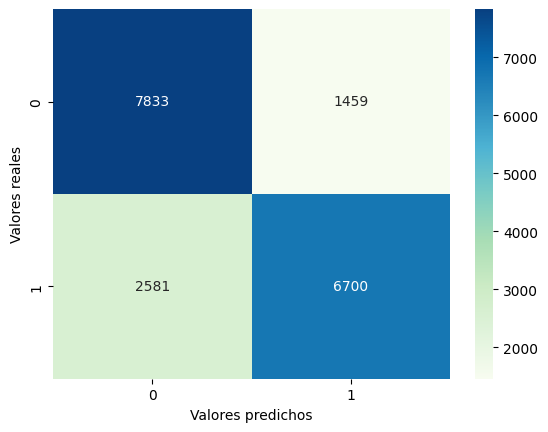

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_minmax)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

<b> Conclusión: </b> tenemos mejores métricas con standard scaler

### Optimizamos kernel y parámetros

Primero probamos con los distintos kernels sin regularizar

Probamos con un kernel lineal:

In [ ]:
clf = SVC(kernel='linear')
clf.fit(x_train_minmax, y_train)

y_pred_lin=clf.predict(x_test_minmax)
print(classification_report(y_pred_lin, y_test))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78     10115
           1       0.73      0.80      0.76      8458

    accuracy                           0.77     18573
   macro avg       0.77      0.77      0.77     18573
weighted avg       0.77      0.77      0.77     18573



Probamos con un kernel polinómico:

In [ ]:
clf = SVC(kernel='poly')
clf.fit(x_train_minmax, y_train)

y_pred_pol=clf.predict(x_test_minmax)
print(classification_report(y_pred_pol, y_test))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80     10305
           1       0.73      0.82      0.77      8268

    accuracy                           0.79     18573
   macro avg       0.78      0.79      0.78     18573
weighted avg       0.79      0.79      0.79     18573



Ahora probamos regularizando:

In [ ]:
clf = SVC(kernel='linear', C=5)
clf.fit(x_train_minmax, y_train)

y_pred_lin=clf.predict(x_test_minmax)
print(classification_report(y_pred_lin, y_test))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     10043
           1       0.73      0.80      0.76      8530

    accuracy                           0.77     18573
   macro avg       0.77      0.78      0.77     18573
weighted avg       0.78      0.77      0.77     18573



In [ ]:
clf = SVC(kernel='poly', C = 5)
clf.fit(x_train_minmax, y_train)

y_pred_pol=clf.predict(x_test_minmax)
print(classification_report(y_pred_pol, y_test))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81     10018
           1       0.76      0.83      0.80      8555

    accuracy                           0.80     18573
   macro avg       0.80      0.81      0.80     18573
weighted avg       0.81      0.80      0.80     18573



In [ ]:
clf = SVC(C = 10)
clf.fit(x_train_norm, y_train)

y_pred_C10=clf.predict(x_test_norm)
print(classification_report(y_pred_C10, y_test))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      9775
           1       0.79      0.84      0.81      8798

    accuracy                           0.82     18573
   macro avg       0.82      0.82      0.82     18573
weighted avg       0.82      0.82      0.82     18573



Text(50.722222222222214, 0.5, 'Valores reales')

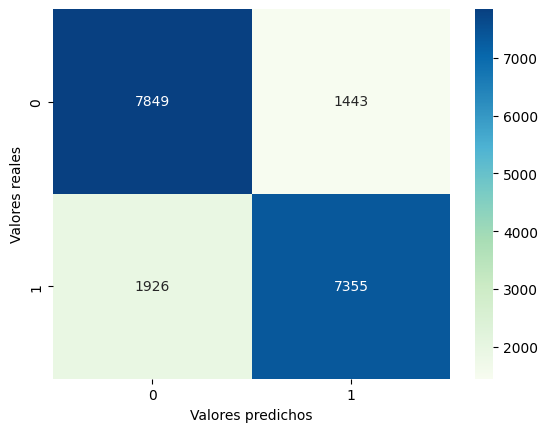

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_C10)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

Realizamos k-fold cv:

In [ ]:
clf = SVC(C = 10)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, ds_train_norm, ds_hoteles_train_y, cv=10)
scores

Probamos crear el modelo con un degree = 5 para un kernel polinómico:

In [ ]:
clf = SVC(kernel='poly',degree= 5, C = 10)
clf.fit(x_train_norm, y_train)
y_pred_pol=clf.predict(x_test_norm)
print(classification_report(y_pred_pol, y_test))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     10312
           1       0.73      0.83      0.78      8130

    accuracy                           0.79     18442
   macro avg       0.79      0.79      0.79     18442
weighted avg       0.80      0.79      0.79     18442



Text(50.722222222222214, 0.5, 'Valores reales')

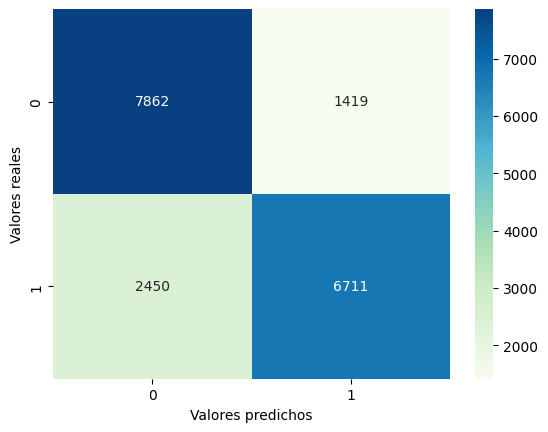

In [ ]:

#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_pol)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### Generamos predicciones con el set de test

Generamos la predicción con el dataset de test con los modelos de mejor resultado:

In [ ]:
clf = SVC(kernel='poly',degree= 5, C = 10)
clf.fit(ds_train_norm, ds_hoteles_train_y)
y_pred_pol=clf.predict(ds_test_norm)

df_submission = pd.DataFrame({'id': ds_hoteles_test_id,'is_canceled': y_pred_pol})
df_submission.info()
df_submission.to_csv('submission_kaggle_svc_c10_d5.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.7+ KB


In [ ]:
clf = SVC(C = 10)
clf.fit(ds_train_norm, ds_hoteles_train_y)
y_pred_C10_test=clf.predict(ds_test_norm)

In [ ]:
df_submission = pd.DataFrame({'id': ds_hoteles_test_id,'is_canceled': y_pred_C10_test})
df_submission.info()
df_submission.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/submission_kaggle_svc_c10.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 621.9+ KB


## Construimos un clasificador RandomForest y optimizamos sus hiperparámetros mediante k-fold Cross Validation


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score


# Crear un clasificador Random Forest
random_forest_model = RandomForestClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [140,160,180,200],
    'max_depth': [40,50,60,70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
    # Otros hiperparámetros de RandomForest aquí
}

# Definir la métrica que quieres optimizar (F1-Score)
scorer_fn = make_scorer(f1_score)

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=random_forest_model,
    param_distributions=param_distributions,
    scoring=scorer_fn,
    cv=5,  # Número de folds para la validación cruzada
    n_iter=20,  # Número de combinaciones aleatorias a probar
    random_state=42  # Semilla aleatoria para reproducibilidad
)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search.fit(ds_hoteles_train_x, ds_hoteles_train_y)

# Obtener la mejor combinación de hiperparámetros
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba (ds_test_x)
y_pred = best_model.predict(ds_test_x)

Mejores hiperparámetros: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 60, 'criterion': 'entropy'}


### Evaluamos sus métricas

In [ ]:
# Crear un clasificador Random Forest con los mejores hiperparámetros
best_random_forest_model = RandomForestClassifier(
    n_estimators=180,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    criterion='entropy',
    random_state=42
)


In [ ]:
#best_random_forest_model = RandomForestClassifier(**best_model.best_params)

# Realizar k-fold cross-validation (por ejemplo, con k=15)
scores = cross_val_score(best_random_forest_model, ds_hoteles_train_x, ds_hoteles_train_y, cv=15, scoring='f1')

# Imprimir los resultados de cada fold
print("F1-score en cada fold:", scores)

# Imprimir la precisión promedio
print("F1-score promedio:", scores.mean())

F1-score en cada fold: [0.85403266 0.86559803 0.84752575 0.8527868  0.86420975 0.8567201
 0.85132787 0.85062035 0.84304488 0.86063326 0.86436105 0.8528827
 0.84875622 0.86055777 0.86159941]
F1-score promedio: 0.8556437722998517


In [ ]:
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,0


In [ ]:
df_submission.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/Submission_RandomForest.csv',index=False)

### Matriz de confusión

In [ ]:
best_random_forest_model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=60, max_features='log2',
                       n_estimators=180, random_state=42)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      9292
           1       0.87      0.83      0.85      9281

    accuracy                           0.86     18573
   macro avg       0.86      0.86      0.86     18573
weighted avg       0.86      0.86      0.86     18573

F1-Score: 0.8517579631874793


Text(50.722222222222214, 0.5, 'True')

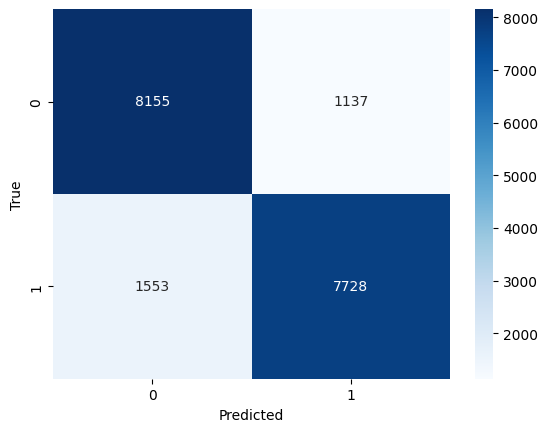

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier


#Predicción sobre el set de evaluacion
y_pred= best_random_forest_model.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))

#Utilizo y_test, que sale de el train_test_split
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1


cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
len(y_test)

18573

## Construimos un clasificador XGBoost y optimizamos sus hiperparámetros.

#### Definición de los hiperparámetros

**Hiper-parámetros**

* learning_rate: tasa de aprendizaje
+ max_depth: máxima profundidad de cada árbol
* subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* n_estimators: cantidad de árboles a construir.
* objective: función de error a utilizar (algunas: reg:linear para regresión,
* reg:logistic o binary:logistic para clasificación)

**Parámetros de regularización:**

* **gamma**: umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha**: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda**: similar alpha pero para la sintonia fina.

### Modelo base de XGBoost

#### Entrenamos un modelo de XGBoost base

In [ ]:
#Creo el modelo y lo entreno

import xgboost as xgb

#Por defecto, el XGBoost se construye con la función objetivo: binary:logistic, que sirve para problemas de clasificación.
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

#### Evaluamos sus métricas

##### Evaluamos con el x_test (del train_test_split)

AUC: 0.9227561835907009
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      9292
           1       0.85      0.82      0.84      9281

    accuracy                           0.84     18573
   macro avg       0.84      0.84      0.84     18573
weighted avg       0.84      0.84      0.84     18573



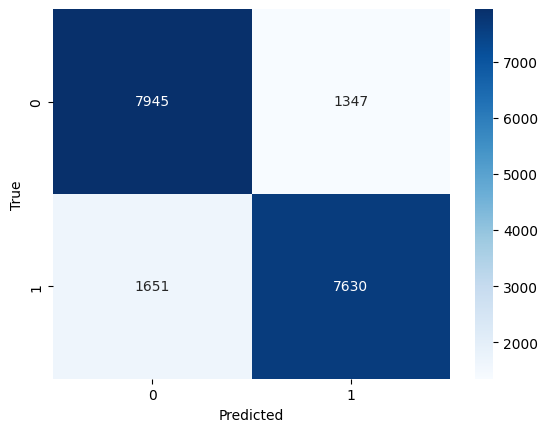

In [ ]:
from sklearn.metrics import f1_score

#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion

y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

##### Hacemos cross validation al DMatrix con learning_rate = 0.1

In [ ]:
#Datos de entrenamiento en formaro DMatrix
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.1},num_boost_round=8,metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.856060,0.000187,0.854612,0.000961
1,0.860849,0.000203,0.859663,0.001161
2,0.862538,0.001290,0.860980,0.001834
3,0.863851,0.000760,0.862196,0.001348
4,0.866734,0.000522,0.864651,0.001123
5,0.868185,0.000836,0.865918,0.000999
6,0.869541,0.001056,0.867260,0.001459
7,0.871861,0.000662,0.869283,0.001004


##### Hacemos cross validation al DMatrix con learning_rate = 0.3

In [ ]:
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=20,params={'learning_rate':0.3},num_boost_round=16,metrics='auc',seed=99,stratified=True)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.855831,0.000360,0.853928,0.006004
1,0.864950,0.000771,0.863033,0.005614
2,0.870531,0.001085,0.867910,0.005495
3,0.875703,0.002199,0.872670,0.005176
4,0.880293,0.001295,0.877168,0.005173
5,0.883949,0.001198,0.880468,0.005383
6,0.887901,0.001368,0.883494,0.005127
7,0.891342,0.001468,0.886484,0.005208
8,0.894798,0.001163,0.888902,0.005446
9,0.897690,0.001432,0.891207,0.005271


### Voy a optimizar los hiperparámetros del XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Creo una instancia de XGBoost con la función objetivo diseñada para problemas de clasificacion (binary:logistic)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

# Defino la grilla de hiperparámetros y sus rangos
param_dist = {
    'learning_rate': uniform(0, 1),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 1),
    'alpha': uniform(0, 1),
    'lambda': uniform(0, 1),
    'n_estimators': randint(50, 200)  # Rango de n_estimators de 50 a 200
}

# Busca el mejor modelo de XGBoost con RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50, ## <--- Prueba 50 combinaciones aleatorias.
    scoring='f1',
    cv=20, ## <-- Prueba con 20 splits para el cross validation
    random_state=0
)

# Realiza la búsqueda aleatoria de hiperparámetros
random_search.fit(ds_hoteles_train_x, ds_hoteles_train_y)

# Obtiene el mejor modelo y los mejores hiperparámetros
best_xgb_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Mejores hiperparámetros del XGBoost:", best_params)

Mejores hiperparámetros del XGBoost: {'alpha': 0.29007760721044407, 'colsample_bytree': 0.8090077144994208, 'gamma': 0.42876870094576613, 'lambda': 0.13547406422245023, 'learning_rate': 0.29828232595603077, 'max_depth': 8, 'n_estimators': 179, 'subsample': 0.7871626244247893}


En la primer ejecución de este código, tira los hiperparámetros:

Mejores hiperparámetros del XGBoost:

{'alpha': 0.29007760721044407, 'colsample_bytree': 0.8090077144994208, 'gamma': 0.42876870094576613, 'lambda': 0.13547406422245023, 'learning_rate': 0.29828232595603077, 'max_depth': 8, 'n_estimators': 179, 'subsample': 0.7871626244247893}


#### Evalúo mi mejor modelo

In [ ]:
# Realizar k-fold cross-validation (por ejemplo, con k=15)
scores = cross_val_score(best_xgb_model, ds_hoteles_train_x, ds_hoteles_train_y, cv=15, scoring='f1')

# Imprimir los resultados de cada fold
print("F1-score en cada fold:", scores)

# Imprimir la precisión promedio
print("F1-score promedio:", scores.mean())

F1-score en cada fold: [0.84982935 0.86190827 0.84562098 0.84640119 0.8536466  0.84701311
 0.84345048 0.84453163 0.83410929 0.85406991 0.85478388 0.85054081
 0.85329415 0.85400926 0.85247501]
F1-score promedio: 0.8497122600391408


#### Visualización de matriz de confusión para modelo optimizado

In [ ]:
# Definir los hiperparámetros
params = {
    'alpha': 0.29007760721044407,
    'colsample_bytree': 0.8090077144994208,
    'gamma': 0.42876870094576613,
    'lambda': 0.13547406422245023,
    'learning_rate': 0.29828232595603077,
    'max_depth': 8,
    'n_estimators': 179,
    'subsample': 0.7871626244247893
}

# Crear el modelo XGBoost con los hiperparámetros
mejor_modelo_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=0,
    **params  # Pasar los hiperparámetros adicionales
)

mejor_modelo_xgb.fit(x_train, y_train)

XGBClassifier(alpha=0.29007760721044407, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8090077144994208, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.42876870094576613,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.13547406422245023,
              learning_rate=0.29828232595603077, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=179, n_jobs=None, ...)

F1-score en el conjunto de prueba: 0.844272984133884
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      9292
           1       0.85      0.84      0.84      9281

    accuracy                           0.85     18573
   macro avg       0.85      0.85      0.85     18573
weighted avg       0.85      0.85      0.85     18573

F1-Score: 0.844272984133884


Text(50.722222222222214, 0.5, 'True')

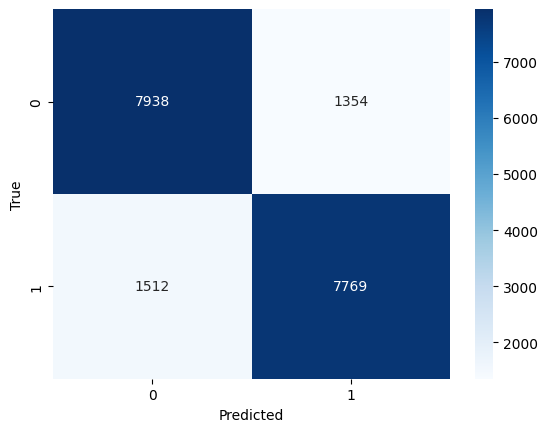

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

# Evalúa el modelo óptimo en el conjunto de prueba
#y_pred = best_xgb_model.predict(x_test)
y_pred = mejor_modelo_xgb.predict(x_test)
f1 = f1_score(y_test, y_pred)
print("F1-score en el conjunto de prueba:", f1)

#Predicción sobre el set de evaluacion
# y_pred= best_random_forest_model.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))

#Utilizo y_test, que sale de el train_test_split
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1


cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#### Exporto tabla para kaggle


In [ ]:
y_pred = best_xgb_model.predict(ds_test_x)
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
df_submission.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/Submission_XGBoost.csv',index=False)

## Construimos un ensamble híbrido tipo Voting y otro tipo Stacking.

### Voting

Visualización teórica del modelo de ensamble tipo voting:
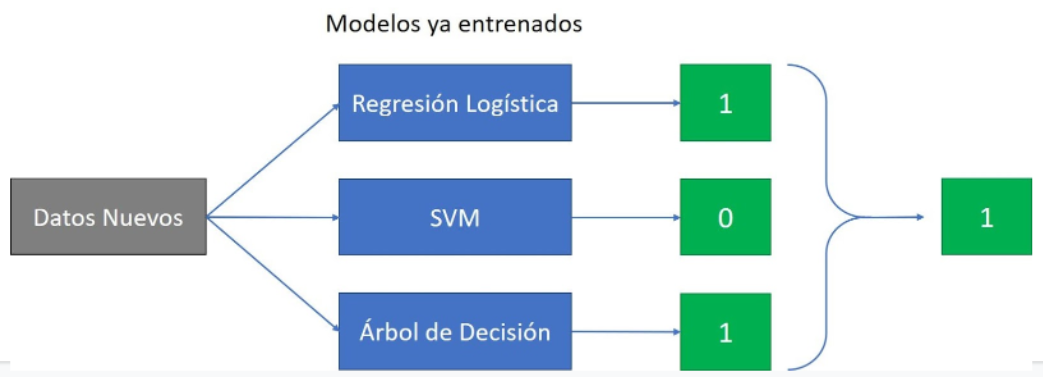

#### Creamos las instancias de los mejores modelos obtenidos de KNN, RandomForest y XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Crear un clasificador Random Forest con los mejores hiperparámetros
best_random_forest_model = RandomForestClassifier(
    n_estimators=180,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    criterion='entropy',
    random_state=42
)

#Creo el mejor clasificador de KNN con los mejores hiperparámetros
knn_mejores_hiperparametros = {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'brute'}
best_knn_model = KNeighborsClassifier(**knn_mejores_hiperparametros)

xgboost_mejores_hiperparametros = {
    'alpha': 0.29007760721044407,
    'colsample_bytree': 0.8090077144994208,
    'gamma': 0.42876870094576613,
    'lambda': 0.13547406422245023,
    'learning_rate': 0.29828232595603077,
    'max_depth': 8,
    'n_estimators': 179,
    'subsample': 0.7871626244247893,
    'objective': 'binary:logistic',
    'random_state': 0
}

best_xgb_model = xgb.XGBClassifier(**xgboost_mejores_hiperparametros)


#### Creamos un ensamble híbrido del tipo Voting con los mejores modelos que tenemos:

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('rnd', best_random_forest_model), ('xgb', best_xgb_model), ('knn', best_knn_model)], voting = 'hard')

#### Entrenamos al modelo de Voting y creamos la matriz de confusión

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      9292
           1       0.87      0.83      0.85      9281

    accuracy                           0.85     18573
   macro avg       0.85      0.85      0.85     18573
weighted avg       0.85      0.85      0.85     18573



Text(50.722222222222214, 0.5, 'True')

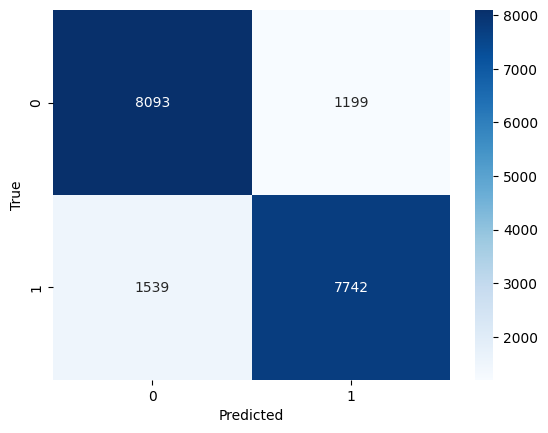

In [ ]:
#Entreno el ensamble con los datasets enteros
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test con x_test, para poder armar la matriz de correlación.
y_pred = vot_clf.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#### Exporto el modelo de voting


In [ ]:
y_pred = vot_clf.predict(ds_test_x)
df_submission_voting = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
#df_submission_voting
df_submission_voting.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/Submission_Voting.csv',index=False)

---
### Stacking

Voy a necesitar (por elección) el:

1. Mejor modelo de XGBoost
2. Mejor modelo de RandomForest
3. Mejor modelo de KNN

Visualizacion del modelo de ensamble híbrido stacking
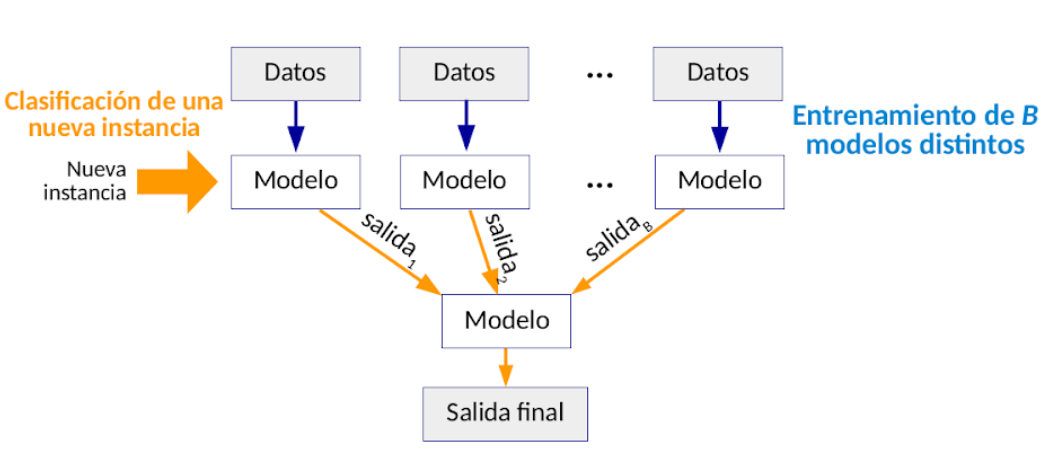

#### Definicion de funciones


##### Defino la funcion para evaluar a cada modelo:

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

##### Defino la función para graficar la performance de cada modelo

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):

    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

#### Creamos las instancias de los mejores modelos obtenidos de KNN, RandomForest y XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Crear un clasificador Random Forest con los mejores hiperparámetros
best_random_forest_model = RandomForestClassifier(
    n_estimators=180,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    criterion='entropy',
    random_state=42
)

#Creo el mejor clasificador de KNN con los mejores hiperparámetros
knn_mejores_hiperparametros = {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'brute'}
best_knn_model = KNeighborsClassifier(**knn_mejores_hiperparametros)

xgboost_mejores_hiperparametros = {
    'alpha': 0.29007760721044407,
    'colsample_bytree': 0.8090077144994208,
    'gamma': 0.42876870094576613,
    'lambda': 0.13547406422245023,
    'learning_rate': 0.29828232595603077,
    'max_depth': 8,
    'n_estimators': 179,
    'subsample': 0.7871626244247893,
    'objective': 'binary:logistic',
    'random_state': 0
}

best_xgb_model = xgb.XGBClassifier(**xgboost_mejores_hiperparametros)


#### Creo el modelo de ensamble híbrido de stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
import plotly.graph_objects as go

#Modelos Base
base_models = [('xgboost', best_xgb_model),
               ('random_forest', best_random_forest_model),
               ('knn', best_knn_model)]

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models:
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, ds_hoteles_train_x, ds_hoteles_train_y)
    model_scores[name] = scores

#Meta modelo, donde utilizamos la regresion logística por ser un problema de clasificación.
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

Evaluating xgboost


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   26.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating random_forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  9.0min finished


#### Evalúo la performance del modelo de stacking y visualizo


In [ ]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, ds_hoteles_train_x, ds_hoteles_train_y)
model_scores['stacking'] = stacking_scores
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 53.3min finished


#### Creamos la matriz de confusión para el modelo híbrido de Stacking

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [('xgb',best_xgb_model), ('rf',best_random_forest_model)]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)


clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      9281
           1       0.87      0.84      0.85      9161

    accuracy                           0.86     18442
   macro avg       0.86      0.85      0.85     18442
weighted avg       0.86      0.86      0.85     18442



Text(50.722222222222214, 0.5, 'True')

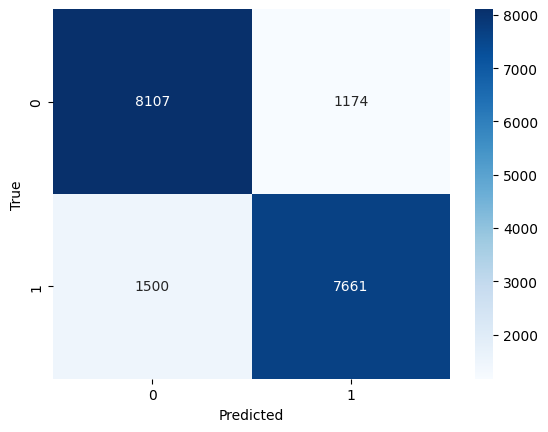

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#### Exporto el modelo de Stacking

In [ ]:
clf.fit(ds_hoteles_train_x, ds_hoteles_train_y)
y_pred = clf.predict(ds_test_x)
df_submission_stacking = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission_voting.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/Submission_Stacking.csv',index=False)